In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset.csv', usecols=['Main Diagnosis'] + ['word_' + str(i) for i in range(100)])

# Display the first few rows to understand the structure
print(data.head())
print(nlp_data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

          Arrival Time Severity Level           Deparment  \
0  2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1  2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2  2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3  2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4  2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

                                   Main Diagnosis       Discharge Time  \
0                               Pain, unspecified  2023-12-13 16:43:00   
1   

In [4]:
print(data.columns)

Index(['ROWNUM', 'Hospital', 'Eligibility Class', 'Gender', 'Arrival Time',
       'Severity Level', 'Deparment', 'Main Diagnosis', 'Discharge Time',
       'Waiting Time (Minutes)', 'Length of Stay (Minutes)',
       'Treatment Time(Minutes)', 'Cluster', 'No Treatment'],
      dtype='object')


In [5]:
# Drop the 'Main Diagnosis' column
data.drop(columns=['Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Date'] = pd.to_datetime(data['Arrival Time']).dt.date
data['Hour'] = data['Arrival Time'].dt.hour
data['DayOfYear'] = data['Arrival Time'].dt.dayofyear
data['Month'] = data['Arrival Time'].dt.month
data['Hour'] = data['Arrival Time'].dt.hour
data['Weekday'] = data['Arrival Time'].dt.weekday + 1

# Convert Gender to numerical
gender_mapping = {'Female': 0, 'Male': 1}
data['Gender_num'] = data['Gender'].map(gender_mapping)

# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)

print(data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

         Arrival Time  Severity Level           Deparment  \
0 2023-12-13 13:17:48               4  Emergency Medicine   
1 2023-12-08 10:59:28               3  Emergency Medicine   
2 2023-11-05 14:03:02               3  Emergency Medicine   
3 2023-10-07 22:57:41               3  Emergency Medicine   
4 2023-10-21 21:32:17               4  Emergency Medicine   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    1

In [6]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')

In [7]:
# Generate list of NLP feature and time feature columns
feature_columns = ['word_' + str(i) for i in range(100)]
feature_columns += ['DayOfYear','Month', 'Hour', 'Weekday']

# Fill missing values with 0 before scaling
combined_data[feature_columns] = combined_data[feature_columns].fillna(0)

# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

# Reshape data for LSTM [samples, time steps, features]
time_steps = 1  # Each sequence consists of a single time step with multiple features
scaled_features = scaled_features.reshape((scaled_features.shape[0], time_steps, scaled_features.shape[1]))

In [8]:
# Weather Data
weather_data = pd.read_csv('Jubail_weather_2023 copy.csv')

weather_data.drop(columns=['name'], inplace=True)

weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date
weather_data.rename(columns={'datetime': 'Date'}, inplace=True)
print(weather_data.head())

         Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0  2023-01-01     25.0     17.3  21.7          25.0          17.3       21.7   
1  2023-01-02     25.6     17.2  21.8          25.6          17.2       21.8   
2  2023-01-03     26.0     20.1  22.5          26.0          20.1       22.5   
3  2023-01-04     27.0     19.2  22.6          26.6          19.2       22.6   
4  2023-01-05     28.0     20.1  23.5          27.4          20.1       23.4   

    dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
0  14.4      63.7     0.0  ...         37.4       10         10   
1  13.0      60.1     0.0  ...         35.1       10         10   
2  10.8      48.1     0.0  ...         34.4        9         10   
3   8.4      41.4     0.0  ...         22.8        6         10   
4  10.9      45.7     0.0  ...         16.6        7         10   

               sunrise               sunset  moonphase        conditions  \
0  2023-01-01T07:04:18  2023-01-01T17:39

# Autoencoder

In [9]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=True)

In [10]:
# Build the Autoencoder Model

# Autoencoder Model with LSTM
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# Encoder with LSTM
encoded = LSTM(128, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)

# Repeat the encoded features
repeated = RepeatVector(time_steps)(encoded)

# Decoder with LSTM
decoded = LSTM(64, activation='relu', return_sequences=True)(repeated)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(X_train.shape[2], activation='sigmoid'))(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [11]:
# Train the autoencoder
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
304/304 [==============================] - 10s 15ms/step - loss: 0.2324 - val_loss: 0.1722
Epoch 2/50
304/304 [==============================] - 4s 12ms/step - loss: 0.0453 - val_loss: 0.0285
Epoch 3/50
304/304 [==============================] - 4s 12ms/step - loss: 0.0276 - val_loss: 0.0271
Epoch 4/50
304/304 [==============================] - 3s 11ms/step - loss: 0.0267 - val_loss: 0.0263
Epoch 5/50
304/304 [==============================] - 6s 18ms/step - loss: 0.0252 - val_loss: 0.0245
Epoch 6/50
304/304 [==============================] - 6s 19ms/step - loss: 0.0242 - val_loss: 0.0241
Epoch 7/50
304/304 [==============================] - 5s 18ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 8/50
304/304 [==============================] - 4s 14ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 9/50
304/304 [==============================] - 6s 18ms/step - loss: 0.0232 - val_loss: 0.0230
Epoch 10/50
304/304 [==============================] - 6s 18ms/step - loss: 0.0227 - val_l

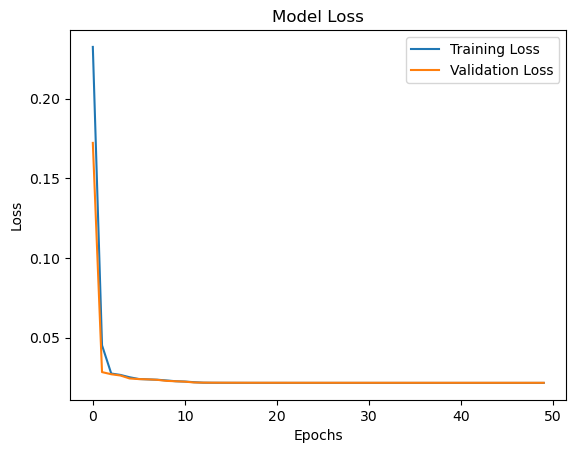

In [12]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

607/607 [==============================] - 3s 3ms/step
MSE Threshold: 0.31339445958466067


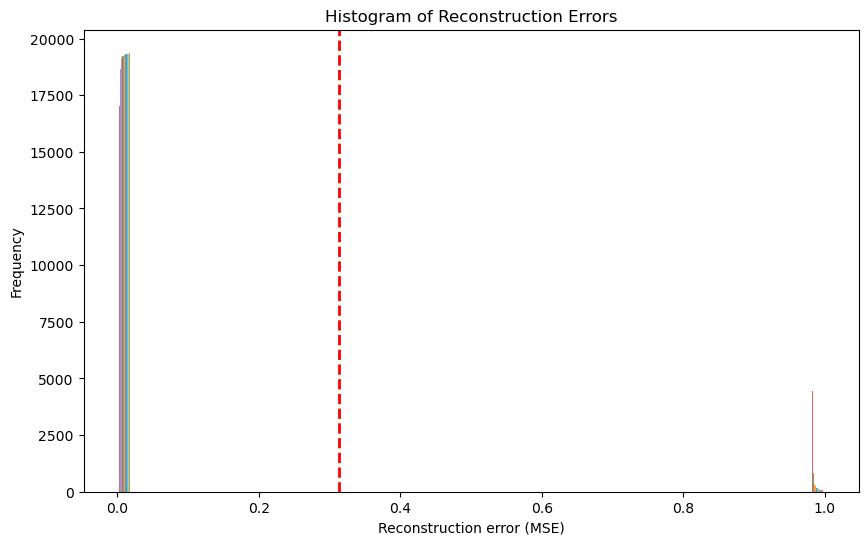

In [13]:
# Get the reconstruction loss on the test set
predictions = autoencoder.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_threshold = np.mean(mse) + 2*np.std(mse)
print(f"MSE Threshold: {mse_threshold}")

plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.75)
plt.axvline(mse_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Frequency')
plt.show()

Example MSE values: [1.90074881e-09 2.93366774e-57 2.81354652e-62 1.20634289e-56
 1.06918388e-65]


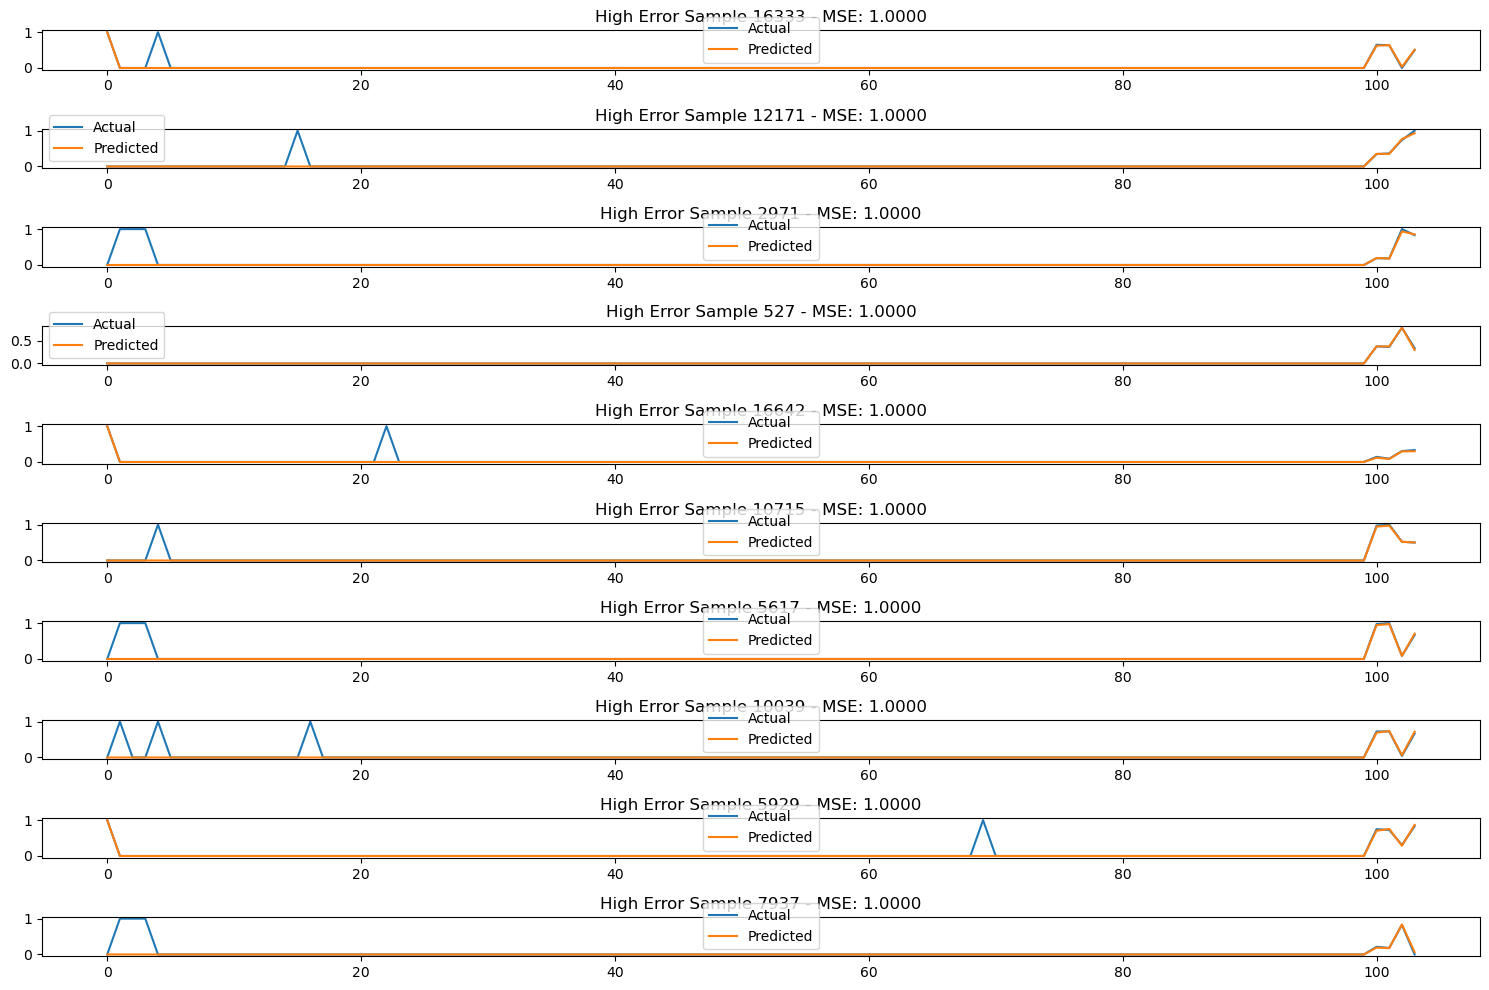

In [14]:
mse = np.array(mse).flatten()
print("Example MSE values:", mse[:5])

# Find indices of high MSE errors that are within the bound of X_test's size
high_error_indices = np.where(mse > mse_threshold)[0]

# Ensuring the indices are within the bounds of X_test and predictions
high_error_indices = high_error_indices[high_error_indices < X_test.shape[0]]

# Choose a number of high-error samples to visualize
num_samples = min(10, len(high_error_indices))
selected_samples = np.random.choice(high_error_indices, size=num_samples, replace=False)

# Plotting the high-error samples
plt.figure(figsize=(15, 10))
for i, index in enumerate(selected_samples, 1):
    plt.subplot(num_samples, 1, i)
    plt.plot(X_test[index].flatten(), label='Actual')
    plt.plot(predictions[index].flatten(), label='Predicted')
    mse_value = mse[index]
    plt.title(f'High Error Sample {index} - MSE: {mse_value:.4f}')
    plt.legend()

plt.tight_layout()
plt.show()


## Anomaly Date Analysis

d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Number of anomalies in df_auto: 416


d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


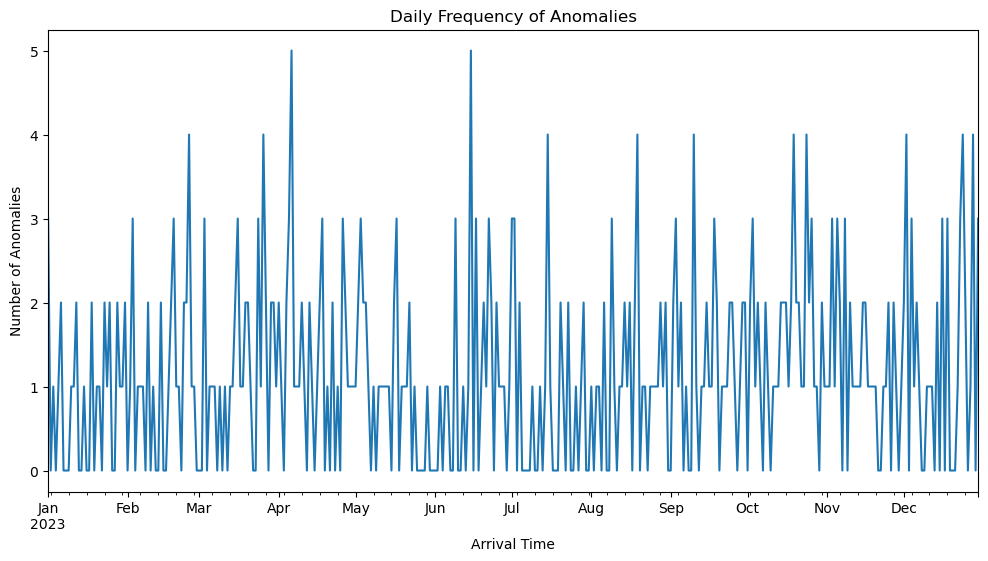

In [15]:
# Create DataFrame for anomalies
df_auto = combined_data.iloc[high_error_indices]
df_auto['MSE'] = mse[high_error_indices]  # Adding the MSE values to the DataFrame
print("Number of anomalies in df_auto:", df_auto.shape[0])

# Ensure 'Arrival Time' is in datetime format (if not already)
df_auto['Arrival Time'] = pd.to_datetime(df_auto['Arrival Time'])

plt.figure(figsize=(12, 6))
df_auto.set_index('Arrival Time', inplace=True)
df_auto['Count'] = 1
df_auto.resample('D').sum()['Count'].plot()  # Daily frequency
plt.title('Daily Frequency of Anomalies')
plt.ylabel('Number of Anomalies')
plt.show()

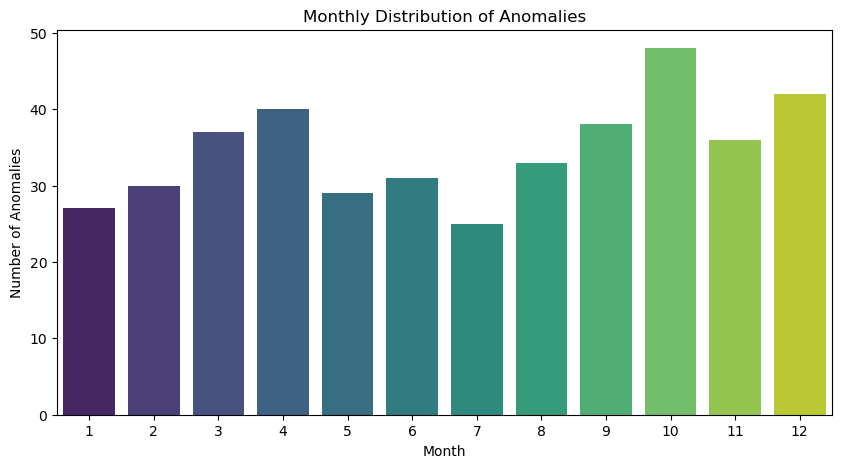

In [55]:
# Plot the monthly distribution of anomalies
monthly_counts_auto = df_auto['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts_auto.index, y=monthly_counts_auto.values, palette='viridis')
plt.title('Monthly Distribution of Anomalies')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.show()

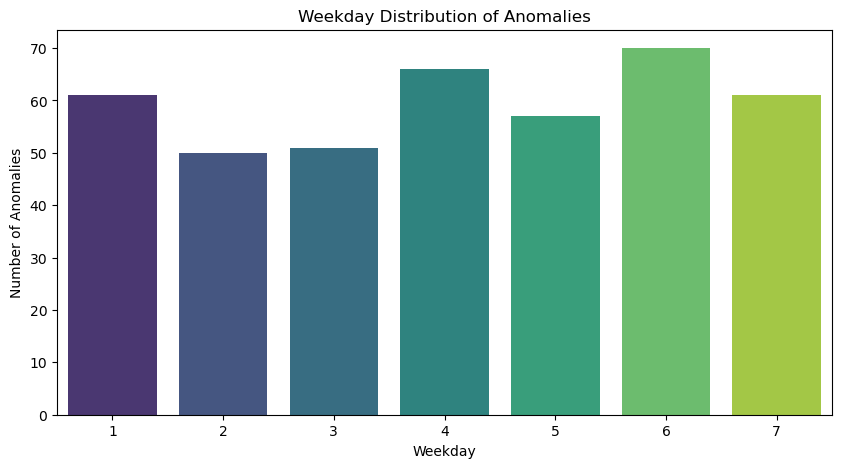

In [56]:
# Weekday Distribution of Anomalies
weekday_counts_auto = df_auto['Weekday'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts_auto.index, y=weekday_counts_auto.values, palette='viridis')
plt.title('Weekday Distribution of Anomalies')
plt.xlabel('Weekday')
plt.ylabel('Number of Anomalies')
plt.show()

d:\Anaconda3\envs\prmls_new\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


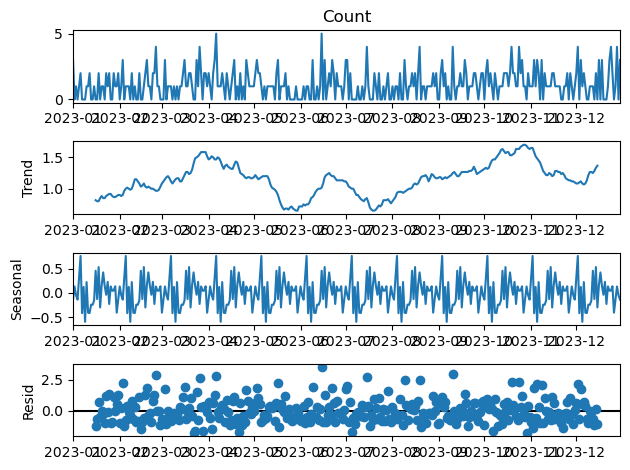

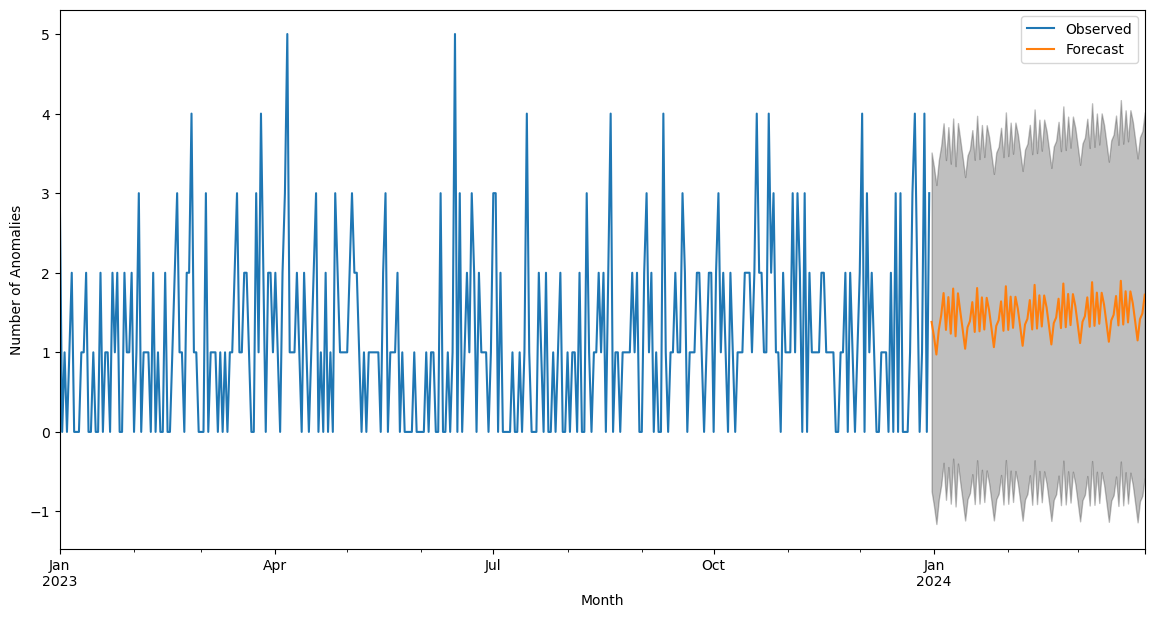

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_auto['Count'] = 1

daily_anomalies_auto = df_auto.resample('D').sum()['Count']

# Seasonal Decomposition
result = seasonal_decompose(daily_anomalies_auto, model='additive', period=30)  # 假设月周期性
result.plot()
plt.show()

# SARIMAX Model
model = SARIMAX(daily_anomalies_auto, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit(disp=False)

# Predict the next 90 days
preds = fitted_model.get_forecast(steps=90)
pred_ci = preds.conf_int()

# Visualize the Predictions
plt.figure(figsize=(14, 7))
ax = daily_anomalies_auto.plot(label='Observed')
preds.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Anomalies')
plt.legend()
plt.show()

## Weather

In [18]:
# Weather Data
# Assuming anomalies_data_auto has a 'Date' column in date format
# Combine the anomalies data with weather data
matched_weather = pd.merge(df_auto['Date'], weather_data, on='Date', how='inner').sort_values(by='Date')
print(matched_weather.head())

           Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
25   2023-01-01     25.0     17.3  21.7          25.0          17.3   
26   2023-01-01     25.0     17.3  21.7          25.0          17.3   
27   2023-01-01     25.0     17.3  21.7          25.0          17.3   
364  2023-01-03     26.0     20.1  22.5          26.0          20.1   
401  2023-01-05     28.0     20.1  23.5          27.4          20.1   

     feelslike   dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
25        21.7  14.4      63.7     0.0  ...         37.4       10         10   
26        21.7  14.4      63.7     0.0  ...         37.4       10         10   
27        21.7  14.4      63.7     0.0  ...         37.4       10         10   
364       22.5  10.8      48.1     0.0  ...         34.4        9         10   
401       23.4  10.9      45.7     0.0  ...         16.6        7         10   

                 sunrise               sunset  moonphase        conditions  \
25   2023-01-0

In [19]:
matched_weather.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,...,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000
mean,34.165865,24.980048,29.297115,36.578125,26.643990,31.615385,17.625000,52.617548,0.233173,10.096154,...,23.038942,207.155048,1009.305288,19.176202,9.404327,290.526202,25.114904,8.699519,22.588942,0.475457
std,6.155056,5.848040,5.718378,9.495890,7.940123,8.502133,4.946709,10.894650,2.042407,30.164056,...,4.236977,108.881796,7.151107,18.612439,0.874694,93.246816,8.059365,1.793858,20.014616,0.289397
min,20.600000,13.200000,17.800000,20.600000,13.200000,17.800000,4.200000,19.100000,0.000000,0.000000,...,14.700000,0.300000,995.400000,0.000000,5.500000,27.800000,2.400000,1.000000,10.000000,0.000000
25%,29.000000,19.625000,24.525000,28.900000,19.625000,24.475000,14.000000,46.675000,0.000000,0.000000,...,20.500000,84.950000,1002.700000,3.775000,9.100000,226.125000,19.425000,8.000000,10.000000,0.207500
50%,34.000000,24.600000,28.850000,34.100000,24.600000,29.300000,17.100000,54.400000,0.000000,0.000000,...,22.800000,242.900000,1010.800000,13.250000,9.800000,293.250000,25.300000,9.000000,10.000000,0.460000
75%,39.600000,30.400000,34.725000,45.325000,33.325000,40.200000,22.300000,60.100000,0.000000,0.000000,...,25.100000,287.200000,1015.325000,28.600000,10.000000,374.150000,32.325000,10.000000,30.000000,0.720000
max,46.000000,36.200000,40.000000,59.600000,47.100000,51.500000,28.600000,73.900000,23.800000,100.000000,...,44.900000,359.900000,1023.500000,77.500000,10.600000,485.600000,42.100000,10.000000,100.000000,0.980000


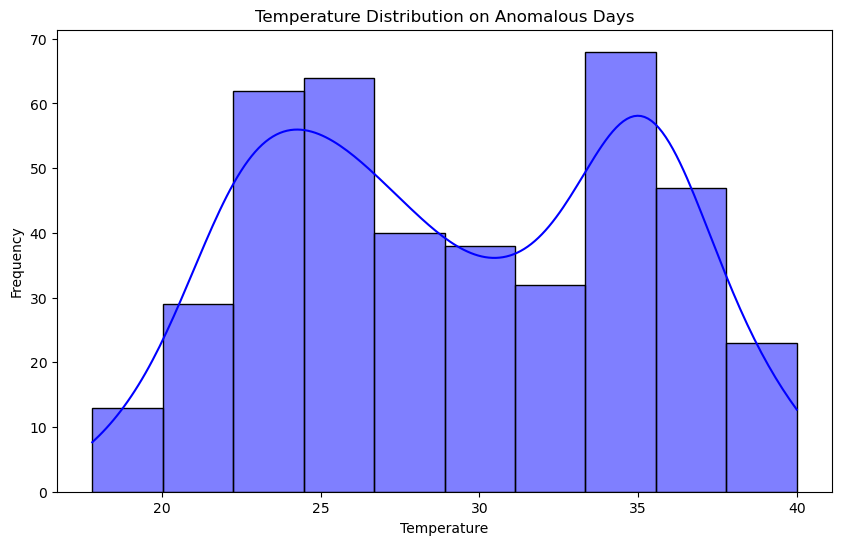

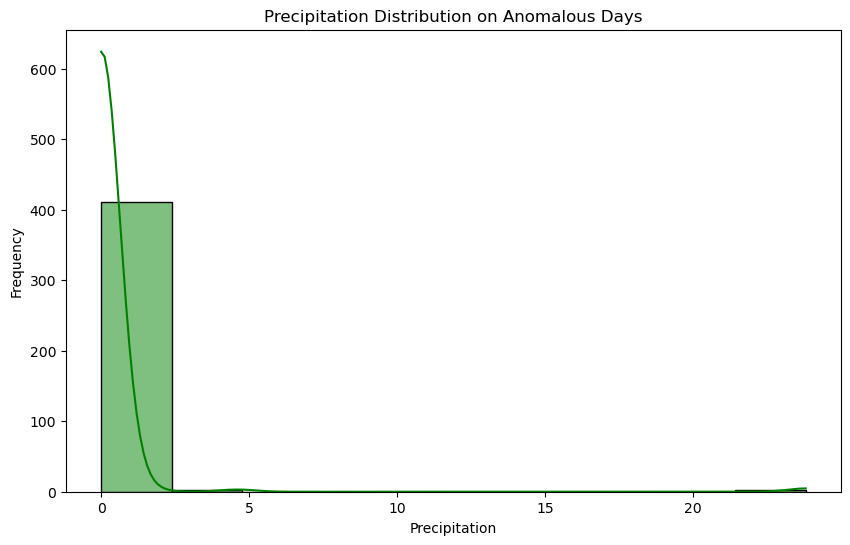

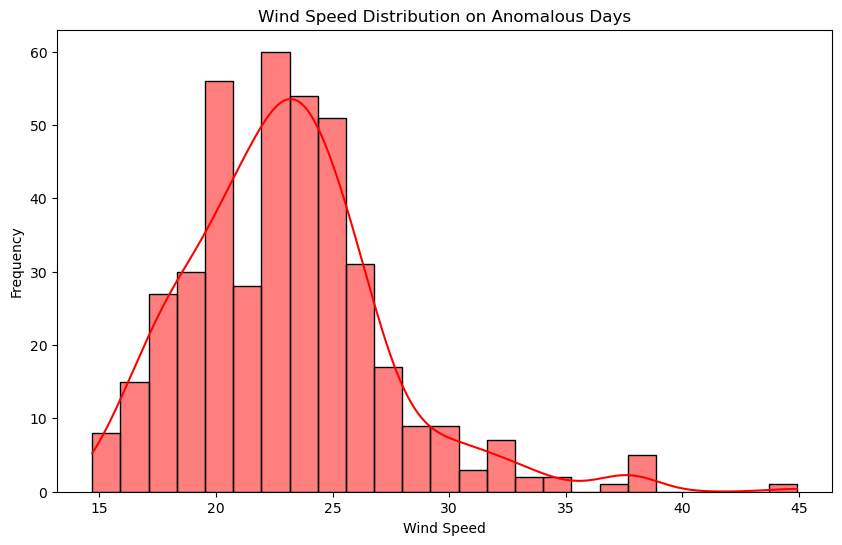

In [20]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomaly Main Diagnosis

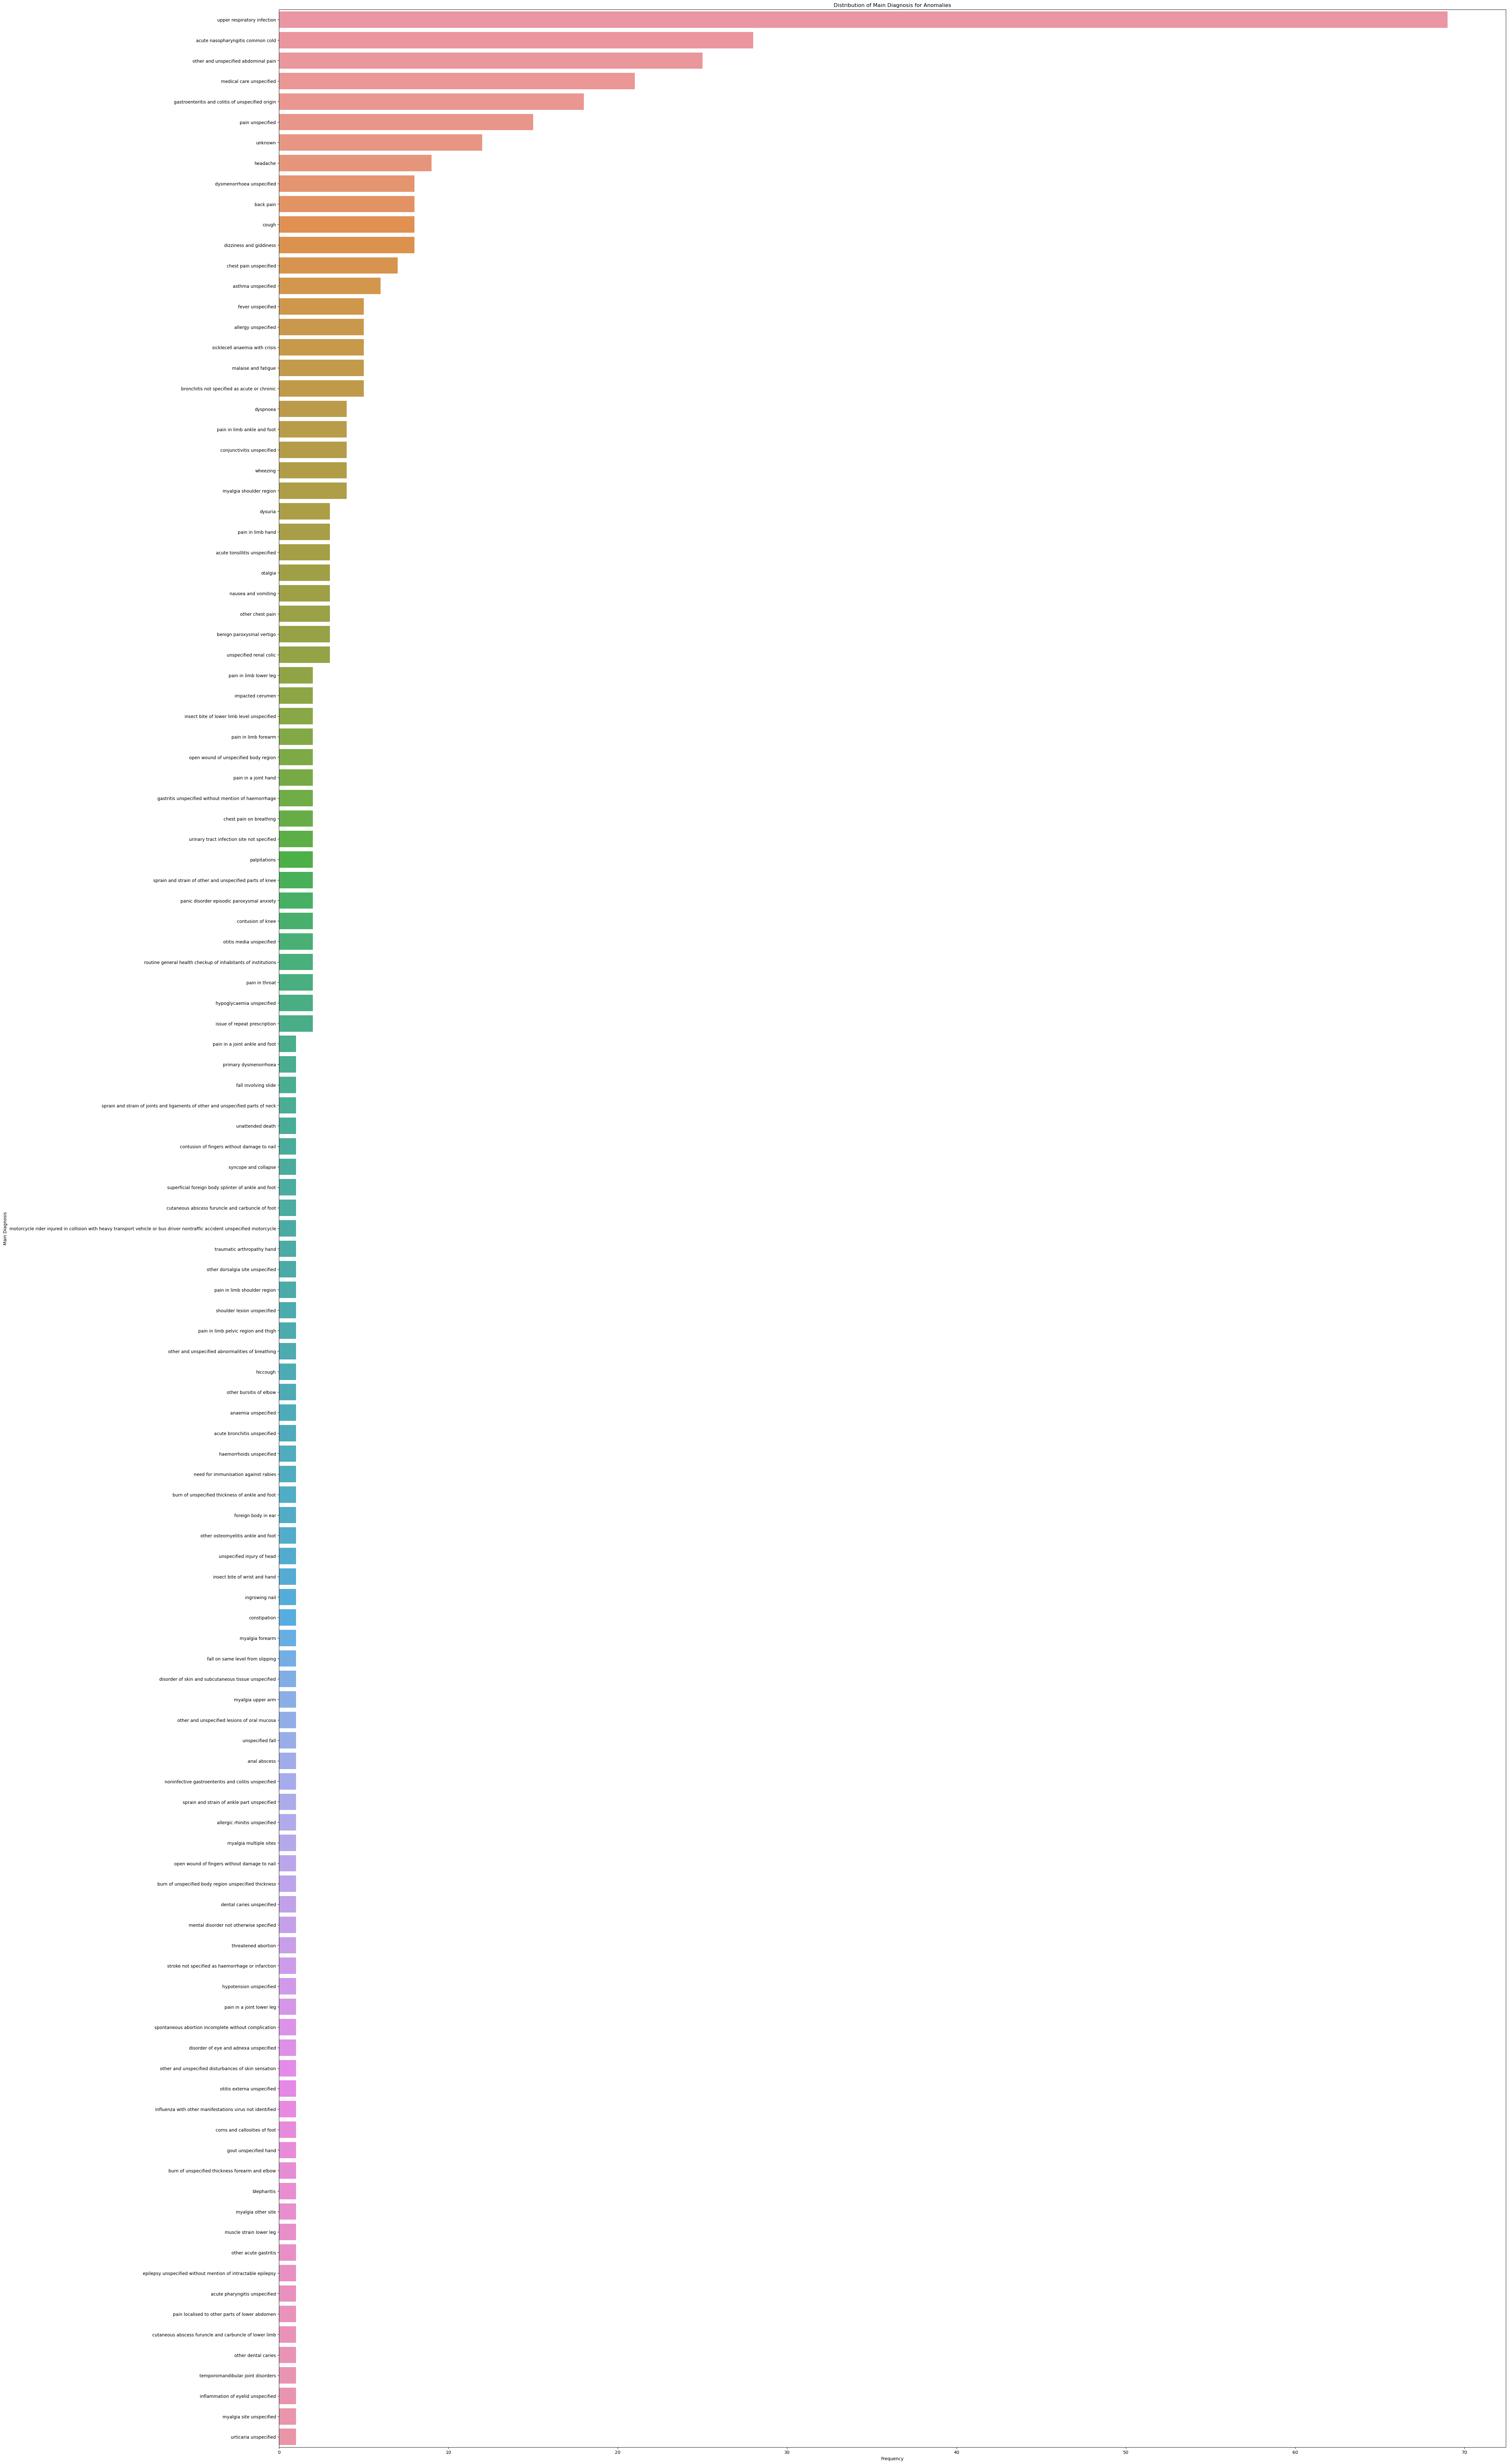

Arrival Time
2023-01-01 06:33:33                                            back pain
2023-01-01 19:27:46                         issue of repeat prescription
2023-01-01 23:59:38                           otitis externa unspecified
2023-01-03 17:27:06                          upper respiratory infection
2023-01-05 16:21:32                             otitis media unspecified
                                             ...                        
2023-12-28 14:37:45                                 pain in a joint hand
2023-12-28 22:24:28                                gout unspecified hand
2023-12-30 00:19:48    burn of unspecified body region unspecified th...
2023-12-30 02:56:24    gastroenteritis and colitis of unspecified origin
2023-12-30 19:35:53                                  threatened abortion
Name: Main Diagnosis, Length: 416, dtype: object


In [21]:
plt.figure(figsize=(50, 100))
sns.countplot(y='Main Diagnosis', data=df_auto, order=df_auto['Main Diagnosis'].value_counts().index)
plt.title('Distribution of Main Diagnosis for Anomalies')
plt.xlabel('Frequency')
plt.show()

df_auto_sorted = df_auto.sort_index()
print(df_auto_sorted['Main Diagnosis'])

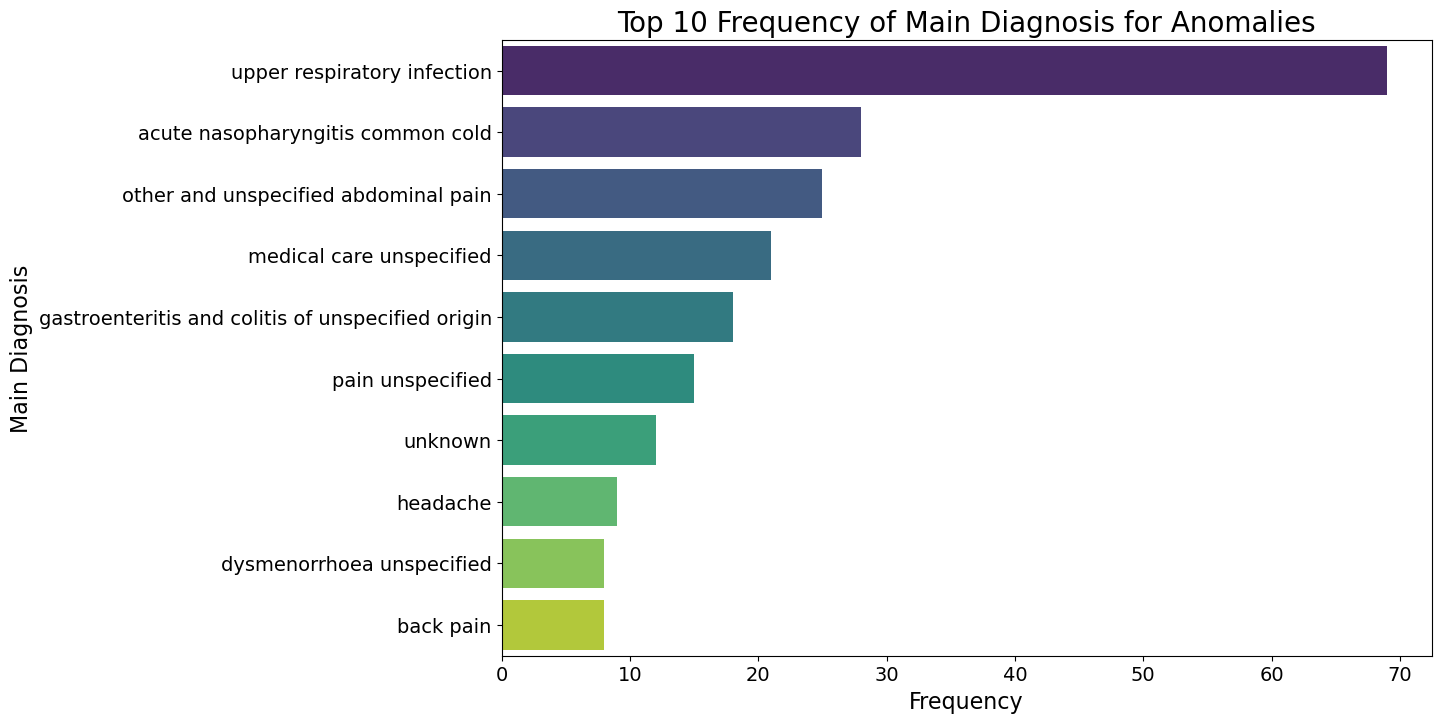

Top 10 Anomalous Main Diagnoses (Autoencoder):
1. upper respiratory infection
2. acute nasopharyngitis common cold
3. other and unspecified abdominal pain
4. medical care unspecified
5. gastroenteritis and colitis of unspecified origin
6. pain unspecified
7. unknown
8. headache
9. dysmenorrhoea unspecified
10. back pain


In [22]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts_auto = df_auto['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(12, 8))
sns.barplot(y=diagnosis_counts_auto.index, x=diagnosis_counts_auto.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("Top 10 Anomalous Main Diagnoses (Autoencoder):")
for idx, diagnosis in enumerate(diagnosis_counts_auto.index, start=1):
    print(f"{idx}. {diagnosis}")

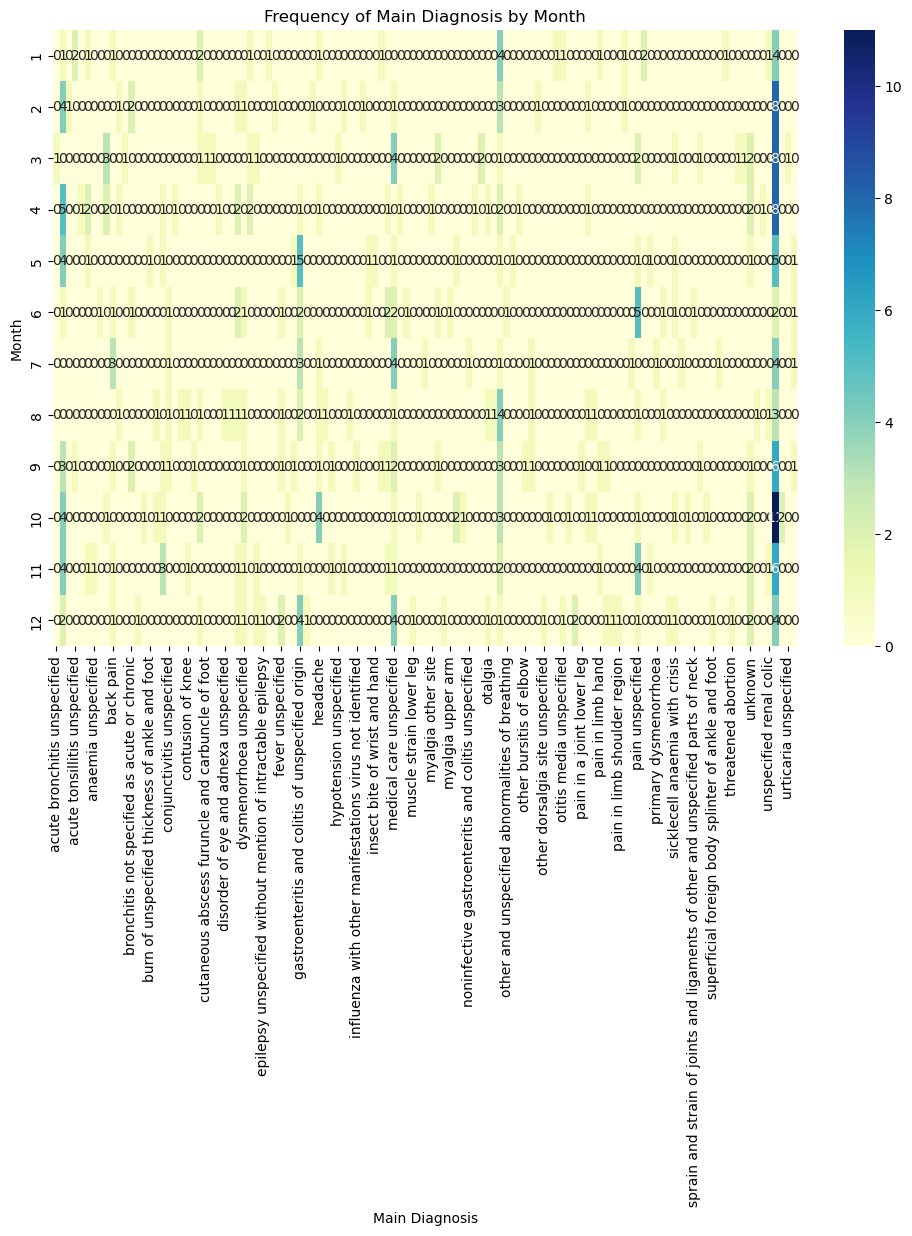

In [23]:
# Group by Month and 'Main Diagnosis' and count occurrences
monthly_diagnosis = df_auto.groupby(['Month', 'Main Diagnosis']).size().unstack(fill_value=0)

# Visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_diagnosis, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Frequency of Main Diagnosis by Month')
plt.xlabel('Main Diagnosis')
plt.ylabel('Month')
plt.show()

Frequency of Main Diagnosis by Month:

The colors in the heatmap range from light to dark. The darker the color, the higher the frequency of that particular diagnosis in the specified month.

In [24]:
# Select diagnoses with frequency greater than or equal to 5 in the specific month
high_frequency_diagnoses = {}
for month in monthly_diagnosis.index:
    filtered_diagnoses = monthly_diagnosis.loc[month][monthly_diagnosis.loc[month] >= 5]
    if not filtered_diagnoses.empty:  # If there are any diagnoses
        high_frequency_diagnoses[month] = filtered_diagnoses

for month, diagnoses in high_frequency_diagnoses.items():
    print(f"Month: {month}:", diagnoses)


Month: 2: Main Diagnosis
upper respiratory infection    8
Name: 2, dtype: int64
Month: 3: Main Diagnosis
upper respiratory infection    8
Name: 3, dtype: int64
Month: 4: Main Diagnosis
acute nasopharyngitis common cold    5
upper respiratory infection          8
Name: 4, dtype: int64
Month: 5: Main Diagnosis
gastroenteritis and colitis of unspecified origin    5
upper respiratory infection                          5
Name: 5, dtype: int64
Month: 6: Main Diagnosis
pain unspecified    5
Name: 6, dtype: int64
Month: 9: Main Diagnosis
upper respiratory infection    6
Name: 9, dtype: int64
Month: 10: Main Diagnosis
upper respiratory infection    11
Name: 10, dtype: int64
Month: 11: Main Diagnosis
upper respiratory infection    6
Name: 11, dtype: int64


# Isolation Forest

In [27]:
# Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model to the data
iso_forest.fit(scaled_features)

# Predict anomalies (-1 means anomaly, 1 means normal)
predictions = iso_forest.predict(scaled_features)

# Add predictions to the original data (for easier analysis)
combined_data['anomaly'] = predictions

# Display the count of anomalies detected
print("Anomalies detected:", np.sum(predictions == -1))

d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\bagging.py:313: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(self.max_features, np.float):
d:\Anaconda3\envs\prmls_new\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing th

Anomalies detected: 4855


In [28]:
# Filter the data to show only the anomalies
anomalies_data_iso = combined_data[combined_data['anomaly'] == -1]

# Display the first few anomalies
print("Anomalous Data:")
print(anomalies_data_iso.head())

Anomalous Data:
    ROWNUM                                  Hospital Eligibility Class  \
39      40  Royal Commission Health Services Program            EXEMPT   
88      89  Royal Commission Health Services Program            EXEMPT   
95      96  Royal Commission Health Services Program  ROYAL COMMISSION   
108    109  Royal Commission Health Services Program            EXEMPT   
120    121  Royal Commission Health Services Program            EXEMPT   

     Gender        Arrival Time  Severity Level           Deparment  \
39   Female 2023-07-28 01:46:02               3  Emergency Medicine   
88   Female 2023-01-10 19:26:05               4  Emergency Medicine   
95   Female 2023-12-23 10:17:49               4  Emergency Medicine   
108  Female 2023-12-24 06:06:30               4  Emergency Medicine   
120    Male 2023-12-31 21:21:47               3  Emergency Medicine   

     Waiting Time (Minutes)  Length of Stay (Minutes)  \
39                     29.0                     125.0  

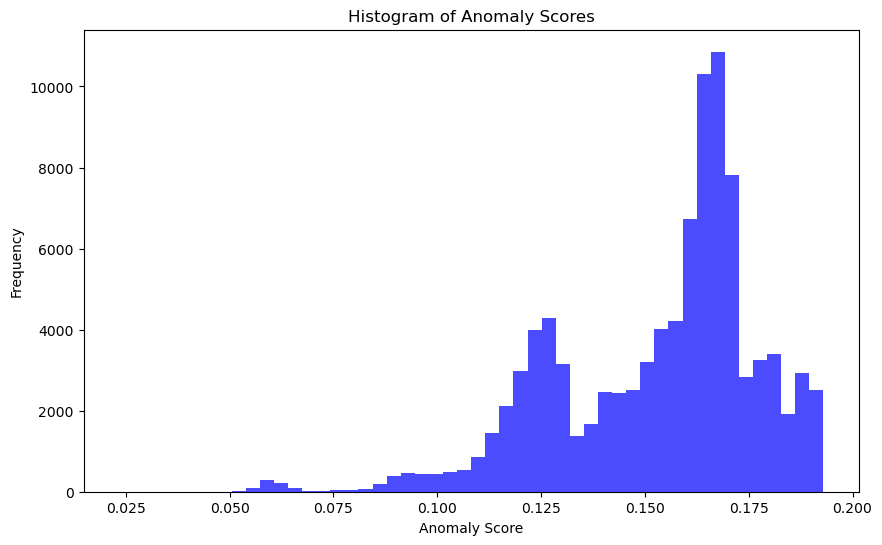

In [29]:
# Calculate anomaly scores (lower is more anomalous)
scores = iso_forest.decision_function(scaled_features)
combined_data['anomaly_score'] = scores

# Visualization of Anomaly Scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

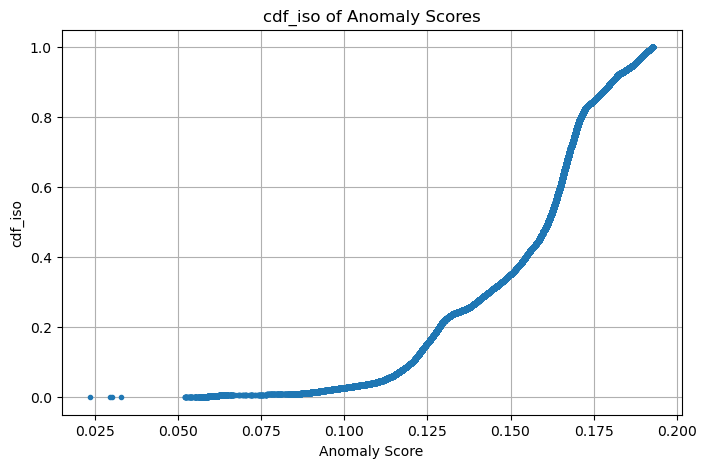

In [46]:
# Calculate the cdf_iso of the anomaly scores
sorted_scores = np.sort(scores)
cdf_iso = np.arange(len(sorted_scores)) / float(len(sorted_scores))

plt.figure(figsize=(8, 5))
plt.plot(sorted_scores, cdf_iso, marker='.', linestyle='none')
plt.xlabel('Anomaly Score')
plt.ylabel('cdf_iso')
plt.title('cdf_iso of Anomaly Scores')
plt.grid(True)
plt.show()

In [80]:
# Set a threshold for anomaly detection
threshold = 0.09

# Mark data points with scores below the threshold as anomalies
combined_data['is_anomaly'] = combined_data['anomaly_score'] < threshold

# Display the anomalies
anomalies = combined_data[combined_data['is_anomaly']]
print(f"Detected {len(anomalies)} anomalies out of {len(combined_data)} records.")


Detected 1319 anomalies out of 97090 records.


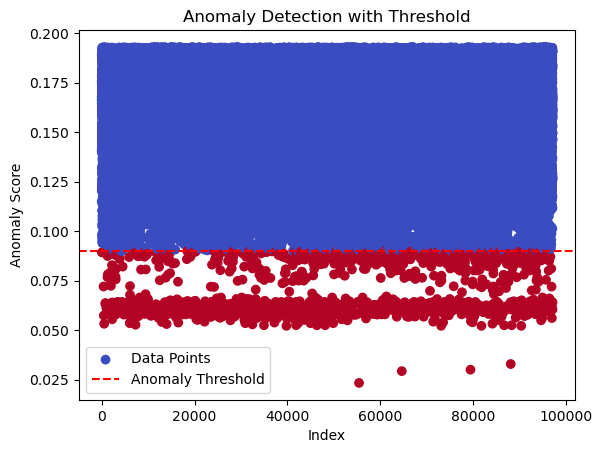

In [81]:
# Visualize the anomaly scores and the threshold
plt.scatter(combined_data.index, combined_data['anomaly_score'], c=combined_data['is_anomaly'], cmap='coolwarm', label='Data Points')
plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Detection with Threshold')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()

## Anomaly Date Analysis

Number of anomalies in df_iso: 1319


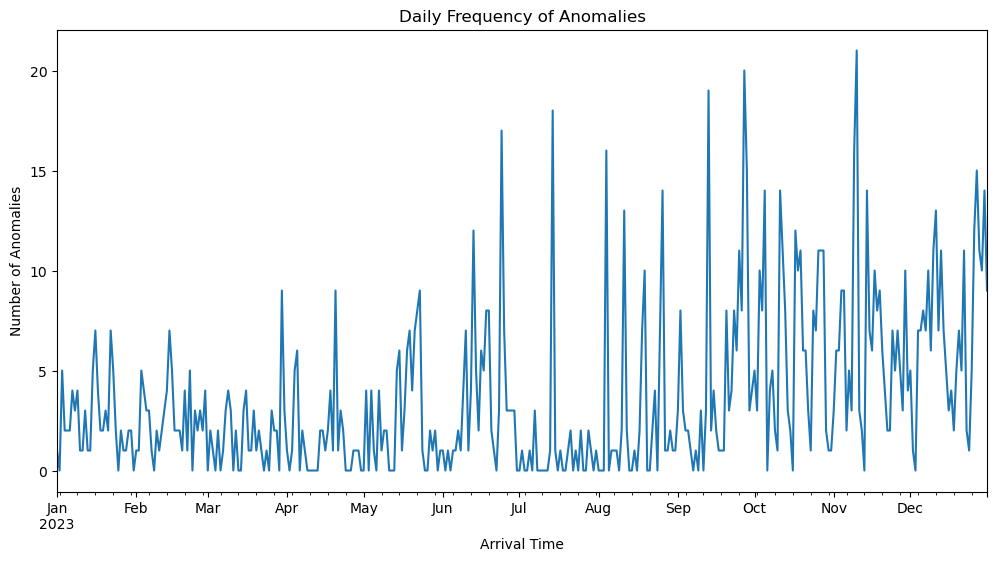

In [82]:
# Create DataFrame for anomalies
df_iso = anomalies.copy()
df_iso['MSE'] = mse[df_iso.index]  # Adding the MSE values to the DataFrame
print("Number of anomalies in df_iso:", df_iso.shape[0])

# Ensure 'Arrival Time' is in datetime format (if not already)
df_iso['Arrival Time'] = pd.to_datetime(df_iso['Arrival Time'])

plt.figure(figsize=(12, 6))
df_iso.set_index('Arrival Time', inplace=True)
df_iso['Count'] = 1
df_iso.resample('D').sum()['Count'].plot()  # Daily frequency
plt.title('Daily Frequency of Anomalies')
plt.ylabel('Number of Anomalies')
plt.show()

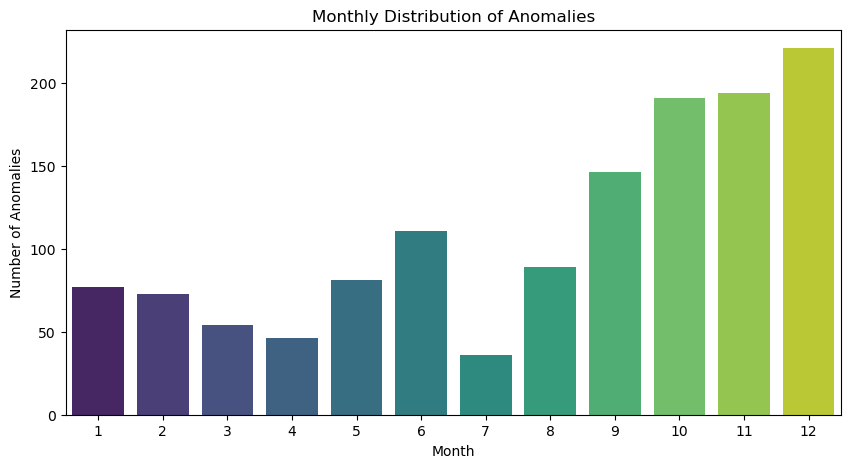

In [83]:
# Plot the monthly distribution of anomalies
monthly_counts_iso = df_iso['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts_iso.index, y=monthly_counts_iso.values, palette='viridis')
plt.title('Monthly Distribution of Anomalies')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.show()

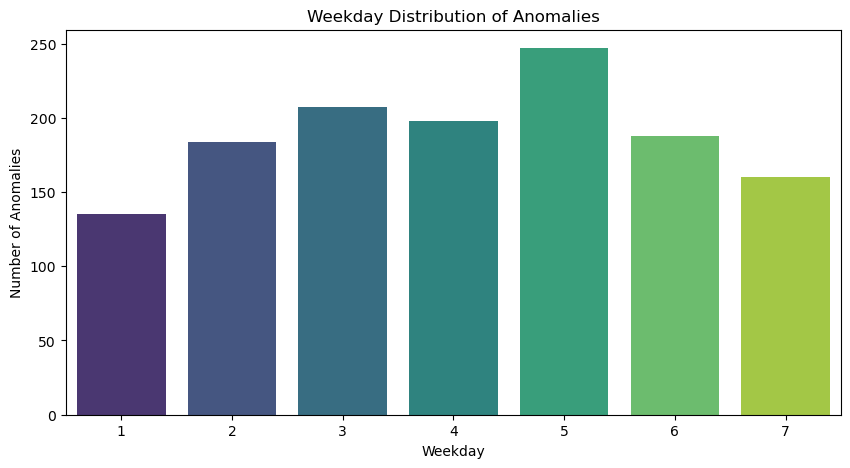

In [84]:
# Weekday Distribution of Anomalies
weekday_counts_iso = df_iso['Weekday'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts_iso.index, y=weekday_counts_iso.values, palette='viridis')
plt.title('Weekday Distribution of Anomalies')
plt.xlabel('Weekday')
plt.ylabel('Number of Anomalies')
plt.show()

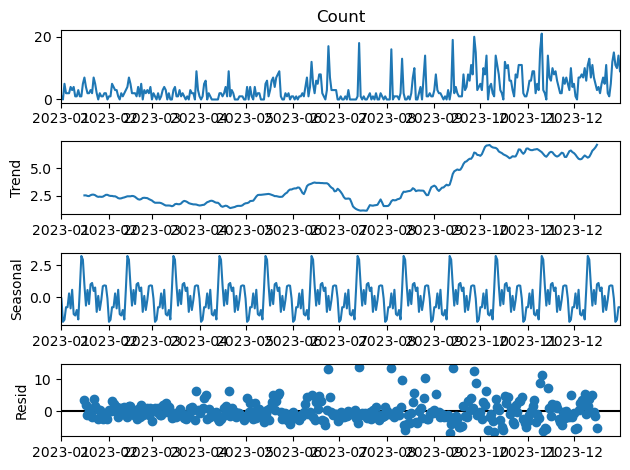

d:\Anaconda3\envs\prmls_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


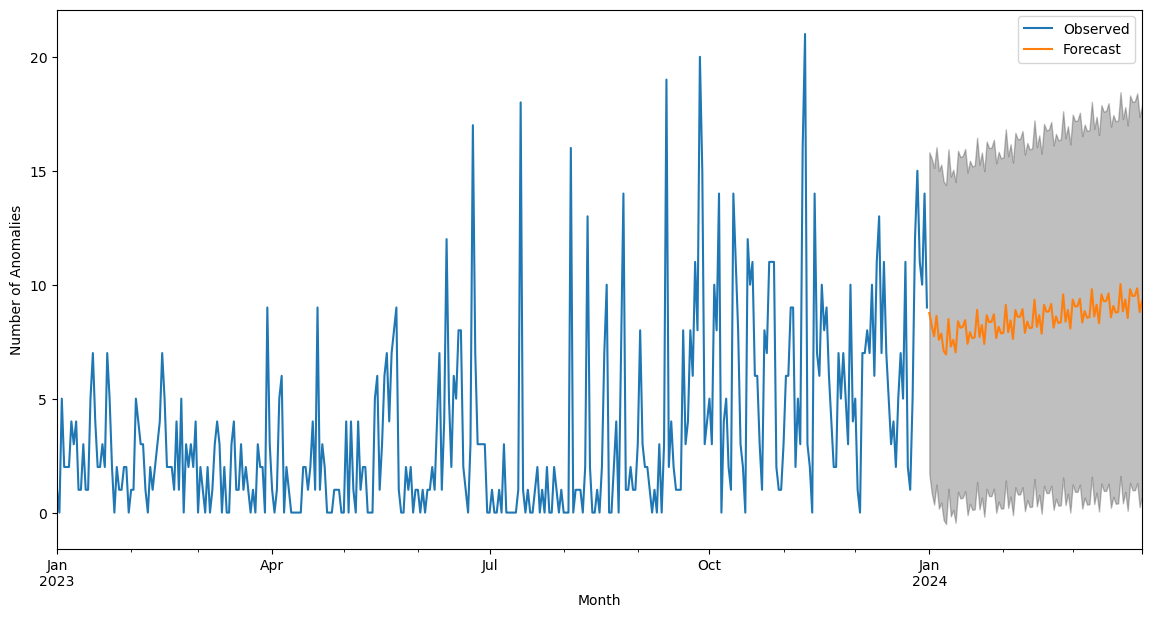

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_iso['Count'] = 1

daily_anomalies = df_iso.resample('D').sum()['Count']

# Seasonal Decomposition
result = seasonal_decompose(daily_anomalies, model='additive', period=30)  # 假设月周期性
result.plot()
plt.show()

# SARIMAX Model
model = SARIMAX(daily_anomalies, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit(disp=False)

# Predict the next 90 days
preds = fitted_model.get_forecast(steps=90)
pred_ci = preds.conf_int()

# Visualize the Predictions
plt.figure(figsize=(14, 7))
ax = daily_anomalies.plot(label='Observed')
preds.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Anomalies')
plt.legend()
plt.show()

1. Count:
This chart shows the raw count of anomaly events over time. There are several significant peaks throughout the year, especially towards the end, indicating possible increases in anomalous activity at specific times.

2. Trend:
The trend chart reveals the long-term movement in the data. It shows a slight upward trend over the course of the year, which may indicate an overall increase in the frequency of anomaly events over time, or an increased sensitivity of the detection methods to anomalies.

3. Seasonal:
The seasonality chart displays periodic variations in the data. It clearly shows regular fluctuations that may be related to seasonal factors such as changes in weather, holidays, or other cyclical events. This chart is particularly useful for identifying specific times of the year when anomalous activity is more frequent.

4. Residual:
The residual chart shows the remaining fluctuations after the trend and seasonal factors have been removed. These fluctuations cannot be explained by the model as either trend or seasonality. Ideally, residuals should be close to zero and show no clear patterns. The residuals here are relatively low and stable, indicating that the model has captured the main structure of the data well, though there are still some fluctuations unexplained by the model.

## Weather

In [85]:
# Weather Data
# Assuming anomalies_data_auto has a 'Date' column in date format
# Combine the anomalies data with weather data
matched_weather_iso = pd.merge(df_iso['Date'], weather_data, on='Date', how='inner').sort_values(by='Date')
print(matched_weather_iso.head())

            Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
1254  2023-01-01     25.0     17.3  21.7          25.0          17.3   
1232  2023-01-03     26.0     20.1  22.5          26.0          20.1   
1231  2023-01-03     26.0     20.1  22.5          26.0          20.1   
1229  2023-01-03     26.0     20.1  22.5          26.0          20.1   
1233  2023-01-03     26.0     20.1  22.5          26.0          20.1   

      feelslike   dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
1254       21.7  14.4      63.7     0.0  ...         37.4       10         10   
1232       22.5  10.8      48.1     0.0  ...         34.4        9         10   
1231       22.5  10.8      48.1     0.0  ...         34.4        9         10   
1229       22.5  10.8      48.1     0.0  ...         34.4        9         10   
1233       22.5  10.8      48.1     0.0  ...         34.4        9         10   

                  sunrise               sunset  moonphase        conditions  \
1

In [86]:
matched_weather_iso.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,...,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,34.270584,25.031994,29.401668,36.415011,26.426763,31.505838,17.432525,52.011069,0.279454,11.448067,...,22.665353,204.309022,1010.187718,18.983927,9.321380,276.436694,23.885671,8.436694,21.031842,0.495239
std,6.118727,5.722665,5.604648,9.085386,7.566252,8.098451,4.755651,11.618200,2.202870,31.851493,...,4.280710,111.332054,7.091942,17.554702,0.917035,91.874882,7.932776,2.071642,17.237268,0.298538
min,18.200000,13.200000,15.900000,18.200000,13.200000,15.900000,4.200000,19.100000,0.000000,0.000000,...,13.400000,0.300000,995.000000,0.000000,5.500000,27.800000,2.400000,1.000000,10.000000,0.000000
25%,28.600000,19.800000,24.300000,28.700000,19.800000,24.100000,14.000000,44.100000,0.000000,0.000000,...,19.900000,85.800000,1004.500000,3.800000,9.000000,202.700000,17.400000,8.000000,10.000000,0.245000
50%,34.000000,24.600000,29.000000,33.100000,24.600000,29.800000,17.200000,54.100000,0.000000,0.000000,...,22.300000,240.400000,1012.100000,15.400000,9.700000,280.100000,24.200000,9.000000,10.000000,0.480000
75%,39.900000,30.400000,34.800000,44.500000,32.300000,38.000000,22.000000,59.900000,0.000000,0.000000,...,24.900000,292.350000,1016.400000,28.050000,10.000000,347.500000,29.950000,10.000000,30.000000,0.790000
max,46.000000,36.200000,40.000000,59.600000,43.400000,48.400000,27.500000,86.400000,23.800000,100.000000,...,44.900000,359.900000,1023.500000,76.600000,10.600000,485.600000,42.100000,10.000000,100.000000,0.980000


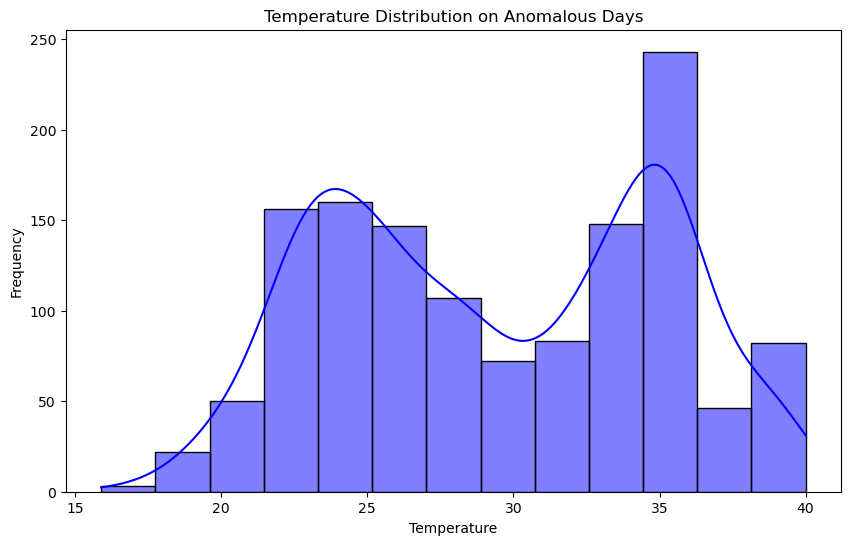

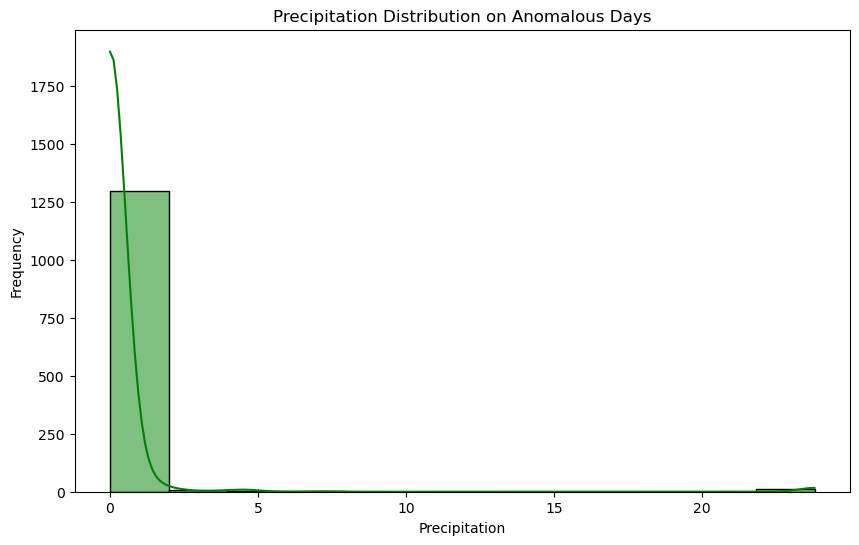

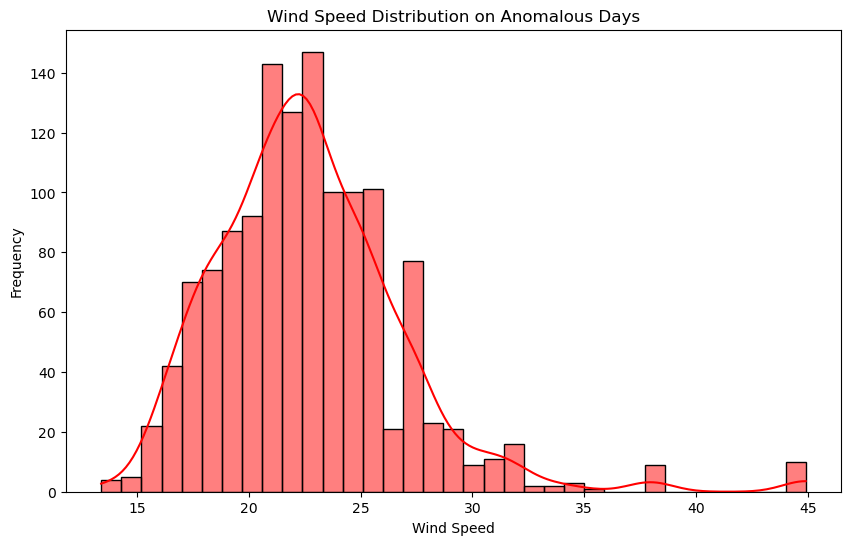

In [87]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomaly Main Diagnosis

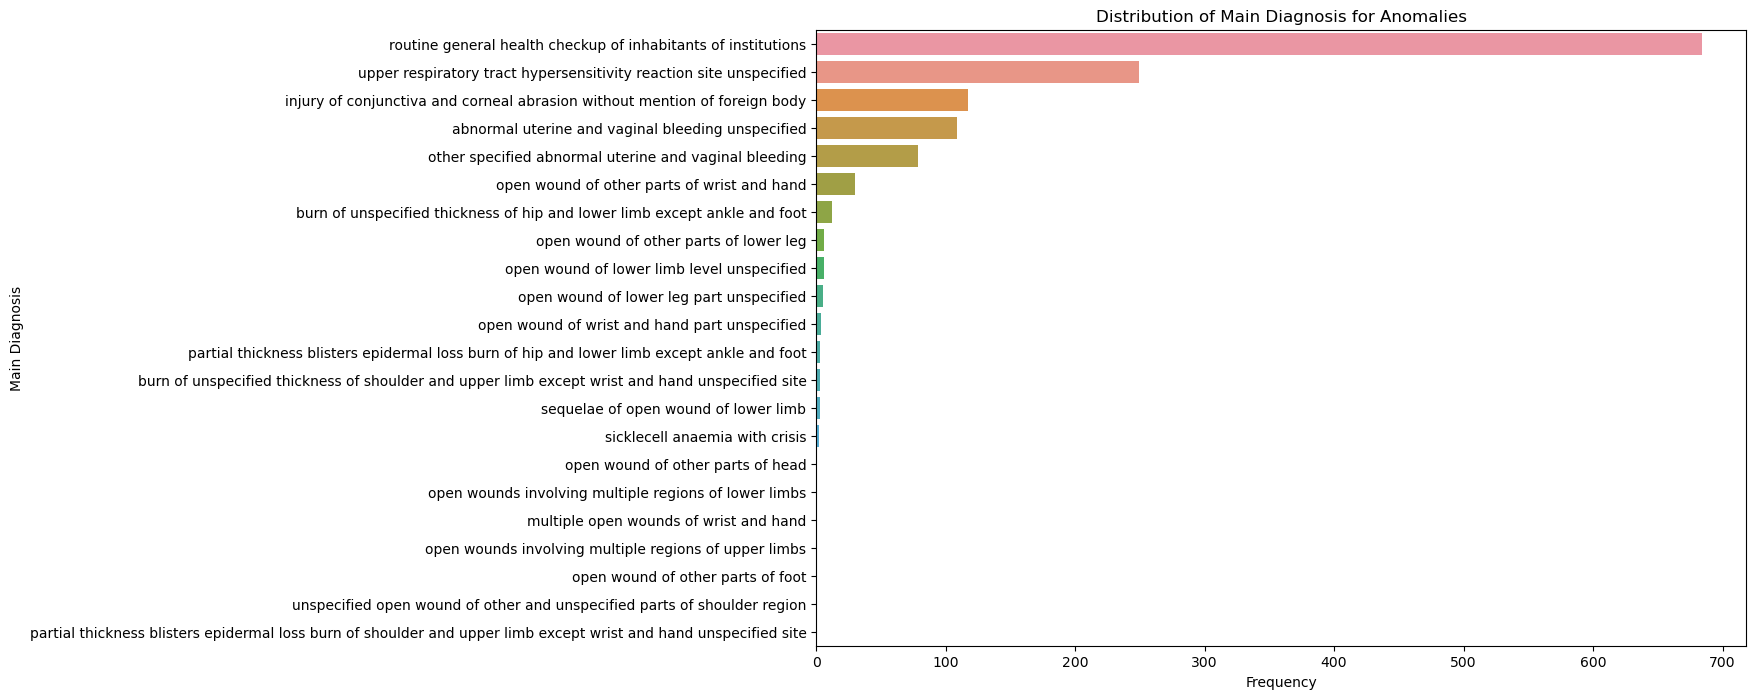

Arrival Time
2023-01-01 07:18:52    abnormal uterine and vaginal bleeding unspecified
2023-01-03 17:06:11          open wound of other parts of wrist and hand
2023-01-03 20:05:59    injury of conjunctiva and corneal abrasion wit...
2023-01-03 20:36:18          open wound of other parts of wrist and hand
2023-01-03 23:13:24    upper respiratory tract hypersensitivity react...
                                             ...                        
2023-12-31 21:50:46    upper respiratory tract hypersensitivity react...
2023-12-31 22:33:13    upper respiratory tract hypersensitivity react...
2023-12-31 23:08:30                    open wound of other parts of foot
2023-12-31 23:30:07    upper respiratory tract hypersensitivity react...
2023-12-31 23:53:53    upper respiratory tract hypersensitivity react...
Name: Main Diagnosis, Length: 1319, dtype: object


In [88]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Main Diagnosis', data=df_iso, order=df_iso['Main Diagnosis'].value_counts().index)
plt.title('Distribution of Main Diagnosis for Anomalies')
plt.xlabel('Frequency')
plt.show()

df_iso_sorted = df_iso.sort_index()
print(df_iso_sorted['Main Diagnosis'])

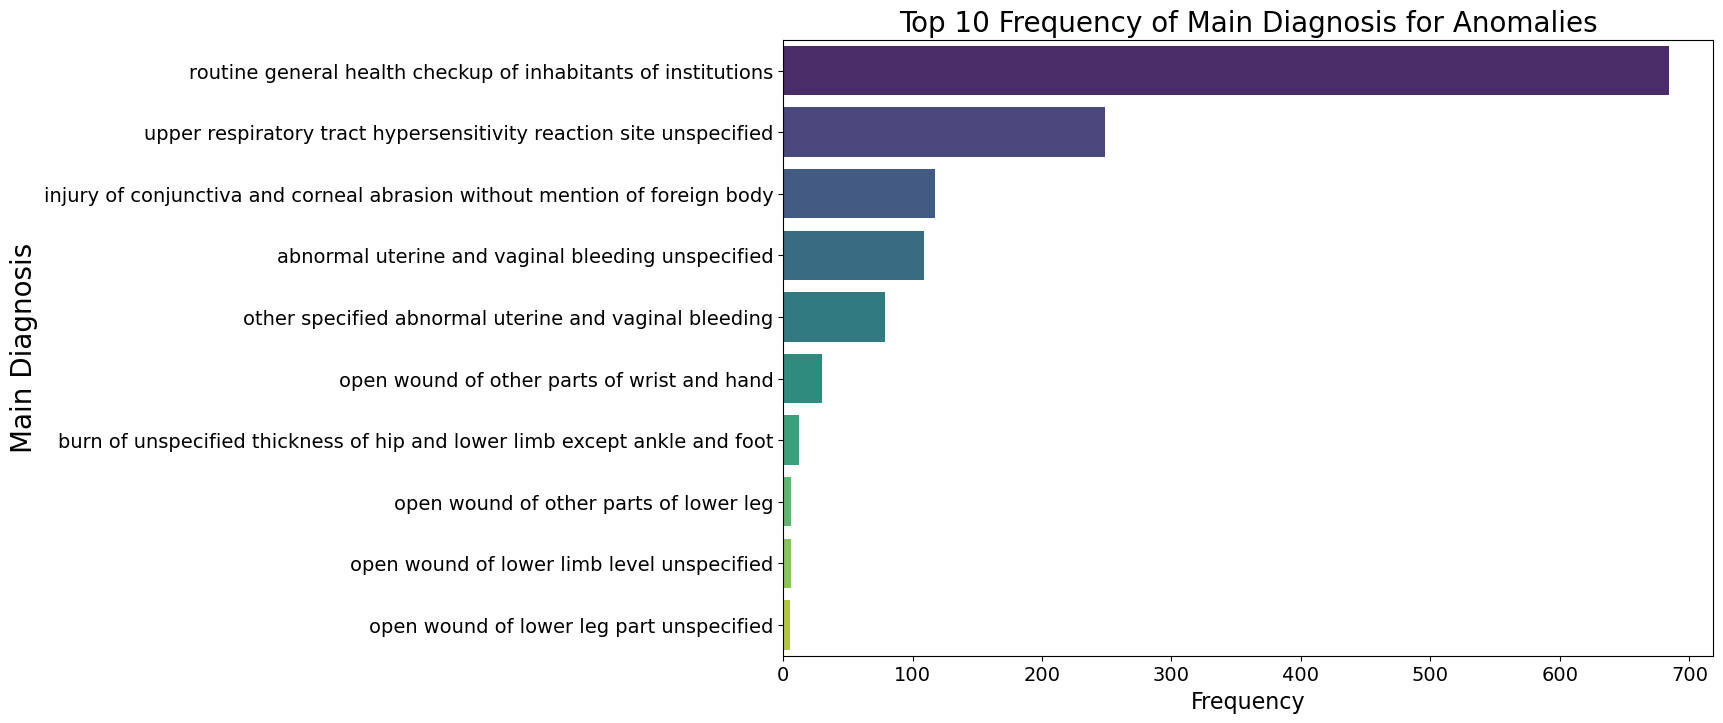

Top 10 Anomalous Main Diagnoses (IsoForest):
1. routine general health checkup of inhabitants of institutions
2. upper respiratory tract hypersensitivity reaction site unspecified
3. injury of conjunctiva and corneal abrasion without mention of foreign body
4. abnormal uterine and vaginal bleeding unspecified
5. other specified abnormal uterine and vaginal bleeding
6. open wound of other parts of wrist and hand
7. burn of unspecified thickness of hip and lower limb except ankle and foot
8. open wound of other parts of lower leg
9. open wound of lower limb level unspecified
10. open wound of lower leg part unspecified


In [89]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts_iso = df_iso['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(12, 8))
sns.barplot(y=diagnosis_counts_iso.index, x=diagnosis_counts_iso.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("Top 10 Anomalous Main Diagnoses (IsoForest):")
for idx, diagnosis in enumerate(diagnosis_counts_iso.index, start=1):
    print(f"{idx}. {diagnosis}")

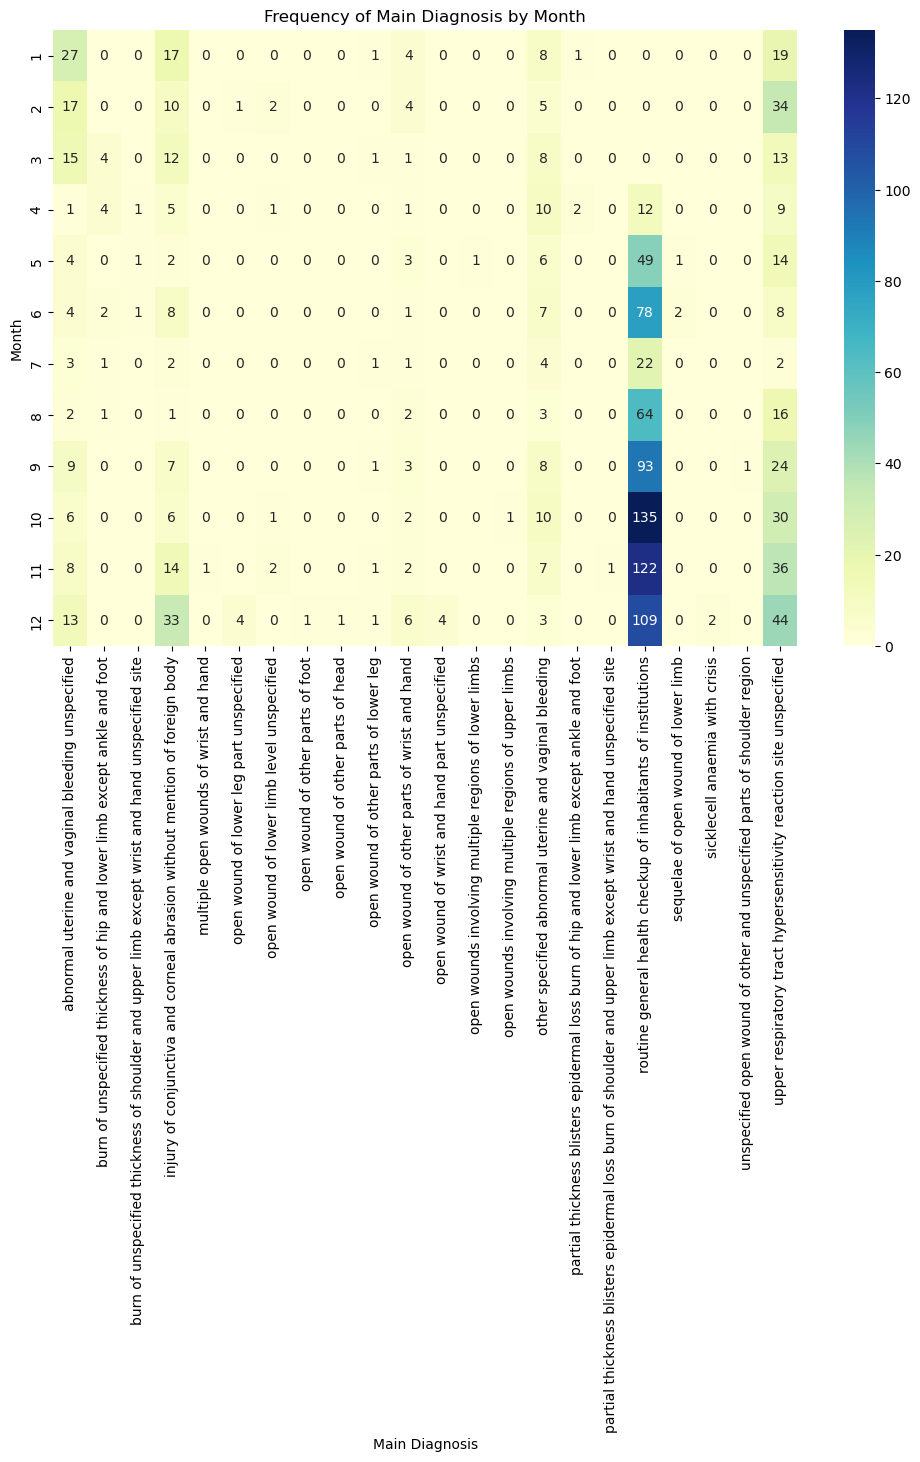

In [90]:
# Group by Month and 'Main Diagnosis' and count occurrences
monthly_diagnosis_iso = df_iso.groupby(['Month', 'Main Diagnosis']).size().unstack(fill_value=0)

# Visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_diagnosis_iso, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Frequency of Main Diagnosis by Month')
plt.xlabel('Main Diagnosis')
plt.ylabel('Month')
plt.show()

# Compare the results of the two models

In the unsupervised learning context, comparing different anomaly detection models like autoencoders and isolation forests presents challenges due to their distinct methodologies for assessing accuracy. The autoencoder model primarily relies on metrics such as the loss function and Mean Squared Error (MSE) to evaluate its performance. In contrast, the isolation forest model utilizes anomaly scores to identify anomalies.

Despite these differences in evaluation metrics, when examining the results from both anomaly detection and time series analysis, the isolation forest model demonstrates a stronger ability to capture and illustrate temporal patterns and trends related to anomalies. When analyzing emergency department data, it allows for a deeper understanding of how anomaly occurrences correlate with specific times of the year. Such insights are crucial for linking anomaly events to seasonal and weather-related variations, thereby enhancing the strategic planning and resource allocation within emergency care settings.

To conclude, we choose Isolation Forest model to do the anomaly detection predictions.

## Making New Prediction

In [98]:

from sklearn.feature_extraction.text import TfidfVectorizer

def make_prediction(Month, Main Diagnosis):
    """
    Predicts whether a patient is an anomaly case based on given features.

    Args:
        Date (int): The arrival time(Date) of the case.
        Main Diagnosis (str): The main diagnosis of the case.

    Returns:
        str: Prediction of whether the patient is an anomaly case.
    """

    # Create DataFrame with input data
    data = {
        "Month": [Month],
        "Main Diagnosis": [Main Diagnosis]
    }

    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])
    vectorizer = TfidfVectorizer()

    # Assuming a pre-fitted CountVectorizer for 'Main Diagnosis' and pre-trained Isolation Forest model
    # Transform 'Main Diagnosis' using the pre-fitted CountVectorizer
    df_new_encoded = vectorizer.transform(df_new['Main Diagnosis'])
    df_new_features = pd.DataFrame(df_new_encoded.toarray(), columns=vectorizer.get_feature_names_out())

    # Combine all features into one DataFrame
    df_final = pd.concat([df_new_features, df_new[['Month']]], axis=1)

    # Predict using the Isolation Forest model
    prediction = iso_forest.predict(df_final)
    
    # Return the prediction result
    if prediction[0] == -1:
        return 'THIS Case Has Higher Probability to be an ANOMALY'
    else:
        return 'THIS CASE IS NOT AN ANOMALY'

# Example usage
print(make_prediction('2023-12','upper respiratory tract hypersensitivity reaction site unspecified'))

SyntaxError: invalid syntax (2440482500.py, line 3)

In [ ]:
make_prediction('2023-12', 'open wound of other parts of foot')